<a href="https://colab.research.google.com/github/pratayusha/PersonDetection_and_FaceBlurring/blob/main/Detectron2_Pytorch_MaskRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

--2023-02-20 06:12:25--  https://i.ytimg.com/vi/NyLF8nHIquM/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 142.251.18.119, 142.250.145.119, 108.177.119.119, ...
Connecting to i.ytimg.com (i.ytimg.com)|142.251.18.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175655 (172K) [image/jpeg]
Saving to: ‘maxresdefault.jpg.1’

maxresdefault.jpg.1 100%[===================>] 171.54K  --.-KB/s    in 0.002s  

2023-02-20 06:12:25 (98.3 MB/s) - ‘maxresdefault.jpg.1’ saved [175655/175655]



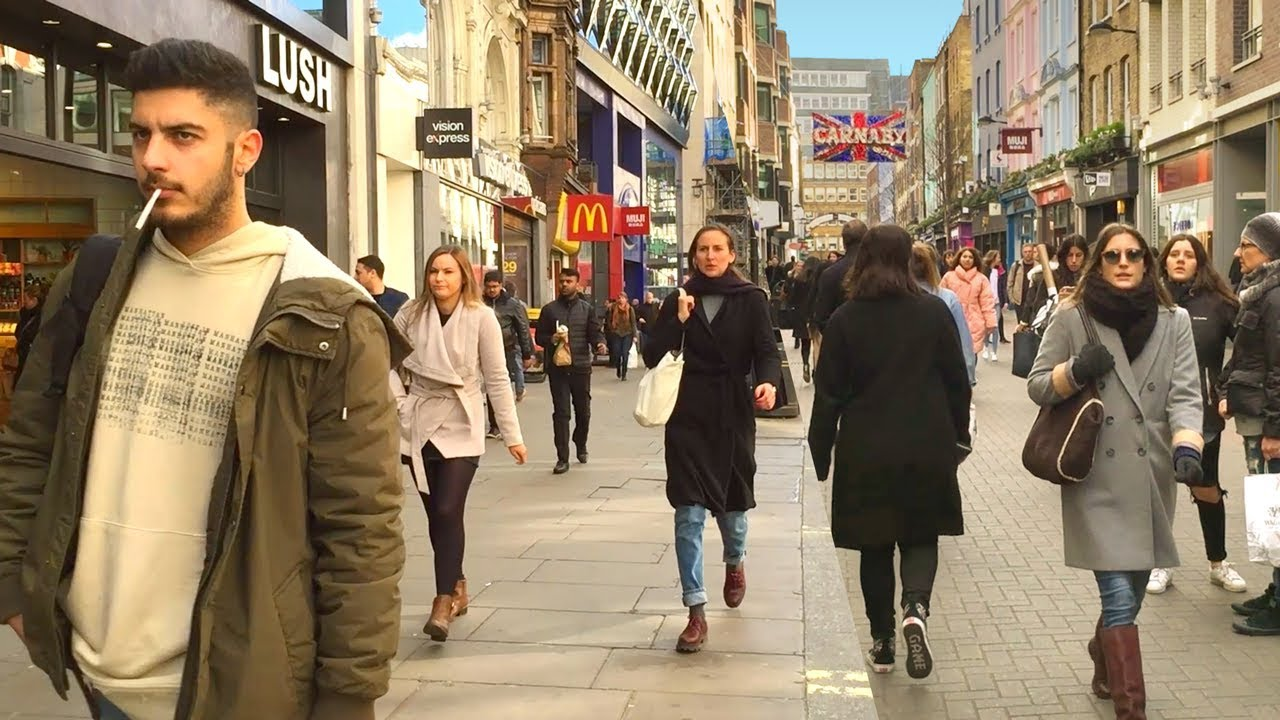

In [40]:
!wget https://i.ytimg.com/vi/NyLF8nHIquM/maxresdefault.jpg
im = cv2.imread('/content/maxresdefault.jpg')
cv2_imshow(im)

In [12]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[02/20 05:42:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:09, 19.5MB/s]                           
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

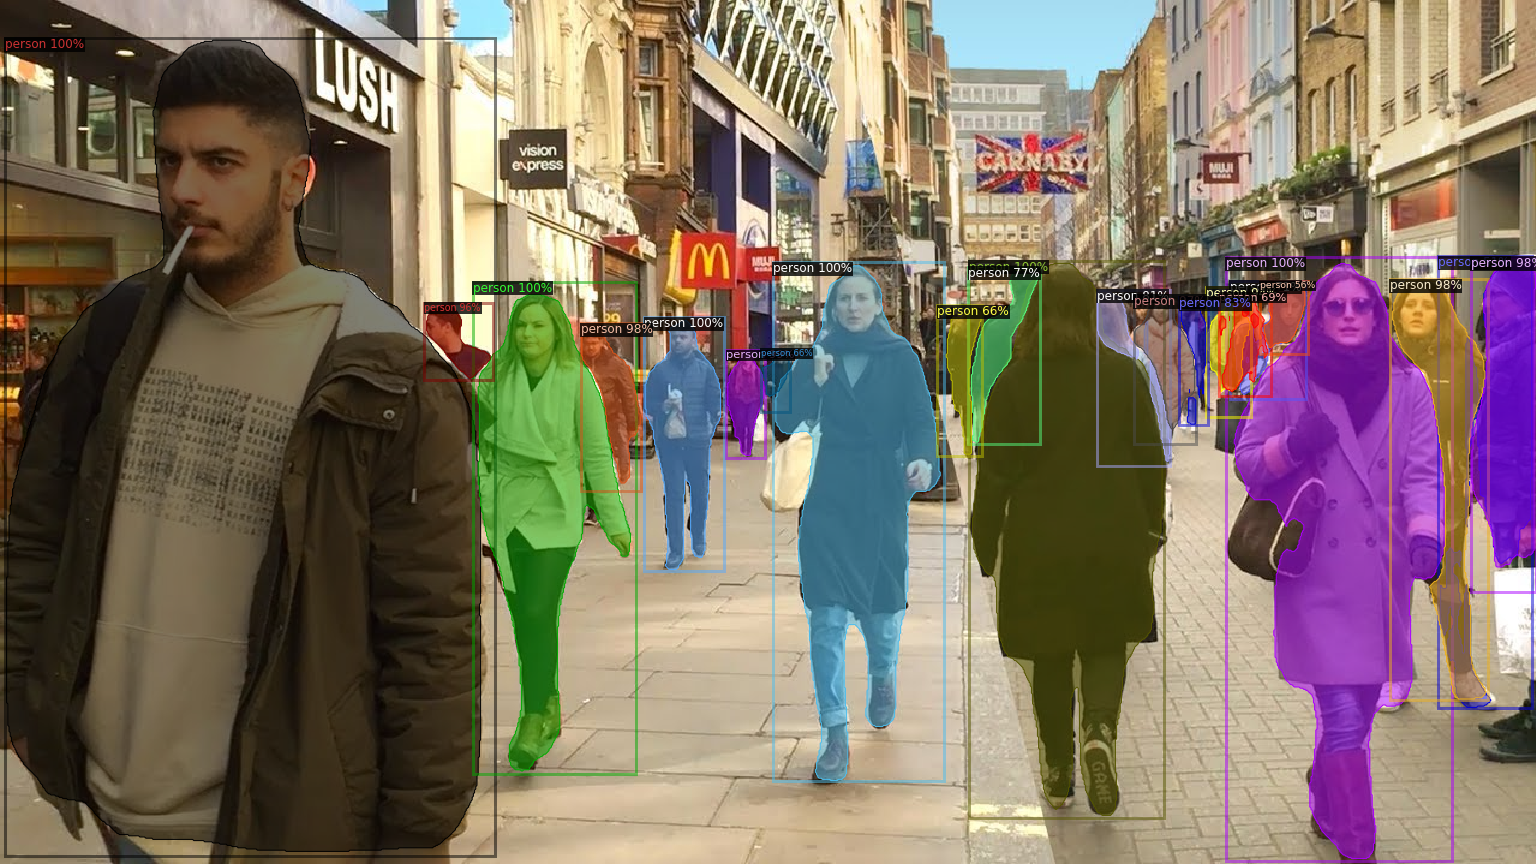

In [41]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)              
# out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
out = v.draw_instance_predictions(outputs['instances'][outputs['instances'].pred_classes == 0].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/3.4/data/haarcascades/haarcascade_frontalface_alt.xml

In [ ]:
test = out.get_image()[:, :, ::-1]
print(type(test))
print(test)
cv2.imwrite('out_test.jpg', test)

In [38]:
image = cv2.imread('out_test.jpg')
  
# Converting BGR image into a RGB image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

face_detect = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
face_data = face_detect.detectMultiScale(image, 1.3, 5)

# Draw rectangle around the faces which is our region of interest (ROI)
for (x, y, w, h) in face_data:
	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
	roi = image[y:y+h, x:x+w]
	# applying a gaussian blur over this new rectangle area
	roi = cv2.GaussianBlur(roi, (23, 23), 30)
	# impose this blurred image on original image to get final image
	image[y:y+roi.shape[0], x:x+roi.shape[1]] = roi

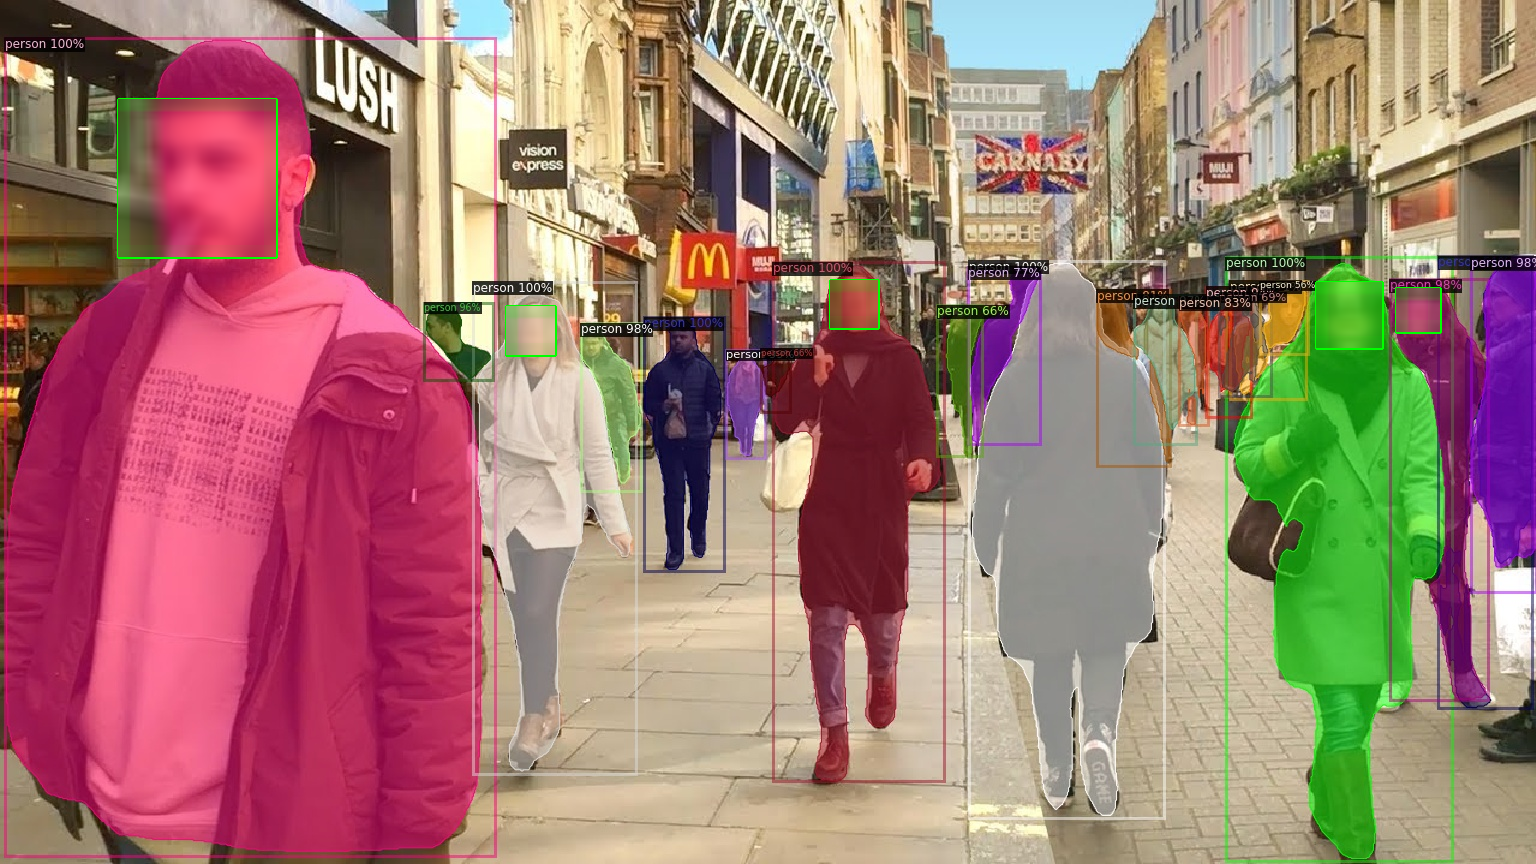

In [42]:
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2_imshow(image)